In [1]:
import numpy as np
import tensorflow as tf
import gym
from sonnet.python.modules.basic import Linear

import pandas as pd
%matplotlib inline

np.random.seed(2)
tf.set_random_seed(2)  # reproducible

In [2]:
# Superparameters
OUTPUT_GRAPH = False
MAX_EPISODE = 30000
DISPLAY_REWARD_THRESHOLD = 200  # renders environment if total episode reward is greater then this threshold
MAX_EP_STEPS = 1000   # maximum time step in one episode
RENDER = False  # rendering wastes time
GAMMA = 0.9     # reward discount in TD error
LR_A = 0.001    # learning rate for actor
LR_C = 0.01     # learning rate for critic

In [3]:
env = gym.make('CartPole-v0')
env.seed(1)  # reproducible
env = env.unwrapped

N_S = env.observation_space.shape[0]
N_A = env.action_space.n

In [4]:
class CriticNetwork(object):
    
    def __init__(self, sess, state_size, gamma=0.9, learing_rate=1e-4):
        self.sess = sess
        self.state = tf.placeholder(tf.float32, [1, state_size], 'state')
        self.next_value = tf.placeholder(tf.float32, [1,1], 'next_value')
        self.reward = tf.placeholder(tf.float32, None, 'reward')
        
        with tf.variable_scope('critic'):
            network = Linear(32, 'input_layer')(self.state)
            network = tf.nn.relu(network)
            network = Linear(1, 'output_layer')(network)
            self.value = network
        
        with tf.variable_scope('squared_TD_error'):
            self.td_error = self.reward + gamma * self.next_value - self.value
            self.loss = tf.square(self.td_error)
        
        with tf.variable_scope('train'):
            self.train_op = tf.train.AdamOptimizer(learing_rate).minimize(self.loss)
        
    def train_step(self, state, reward, next_state):
        state = np.expand_dims(state, axis=0)
        next_state = np.expand_dims(next_state, axis=0)
        next_value = self.sess.run(self.value, feed_dict={self.state:next_state})
        td_error, _ = self.sess.run([self.td_error, self.train_op], 
                                    {self.state:state, self.next_value:next_value, self.reward:reward})
        return td_error 

In [5]:
class ActorNetwork(object):
    def __init__(self, sess, state_size, action_size, learing_rate=1e-4):
        self.sess = sess
        self.state = tf.placeholder(tf.float32, [1, state_size], 'state')
        self.action = tf.placeholder(tf.int32, None, 'action')
        self.td_error = tf.placeholder(tf.float32, [1,1], 'TD_error')
        
        with tf.variable_scope('actor_space'):
            actor_network = Linear(32, 'input_layer')(self.state)
            actor_network = tf.nn.relu(actor_network)
            actor_network = Linear(action_size, 'output_layer')(actor_network)
            actor_network = tf.nn.softmax(actor_network)
            self.act_prob = tf.squeeze(actor_network)            
            
        with tf.variable_scope('exp_prob'):
            log_prob = tf.log(tf.gather(self.act_prob, self.action))
            self.exp_prob = tf.reduce_mean(log_prob * self.td_error)

        with tf.variable_scope('train'):
            self.train_op = tf.train.AdamOptimizer(learing_rate).minimize(-self.exp_prob) 
            
    def train_step(self, state, action, td_error):
        state = np.expand_dims(state, axis=0)
        feed_dict = {self.state:state, self.action:action, self.td_error:td_error}
        _, exp_prob = self.sess.run([self.train_op, self.exp_prob], feed_dict)
        return exp_prob
    
    def action_select(self, state):
        state = np.expand_dims(state, axis=0)
        policy_act_prob = self.sess.run(self.act_prob, {self.state:state})
        policy_action = np.random.choice([0,1], 1, p=policy_act_prob)
        return policy_action[0]

In [6]:
tf.reset_default_graph()
sess = tf.Session()
actor = ActorNetwork(sess, 4, 2)
critic = CriticNetwork(sess, 4)
sess.run(tf.global_variables_initializer())

In [7]:
discount_reward_list = []
for i in range(MAX_EPISODE):
    state = env.reset()
    t = 0
    track_reward = []
    
    while True:
        action = actor.action_select(state)
        next_state, reward, done, info = env.step(action)
        
        if done:
            reward = -100
            
        track_reward.append(reward)
        td_error = critic.train_step(state, reward, next_state)
        actor.train_step(state, action, td_error)

        t += 1
        state = next_state
        
        if done or t >= MAX_EP_STEPS:
            ep_rs_sum = sum(track_reward)

            if 'running_reward' not in globals():
                running_reward = ep_rs_sum
            else:
                running_reward = running_reward * 0.95 + ep_rs_sum * 0.05
            discount_reward_list.append(running_reward)
            break
            

KeyboardInterrupt: 

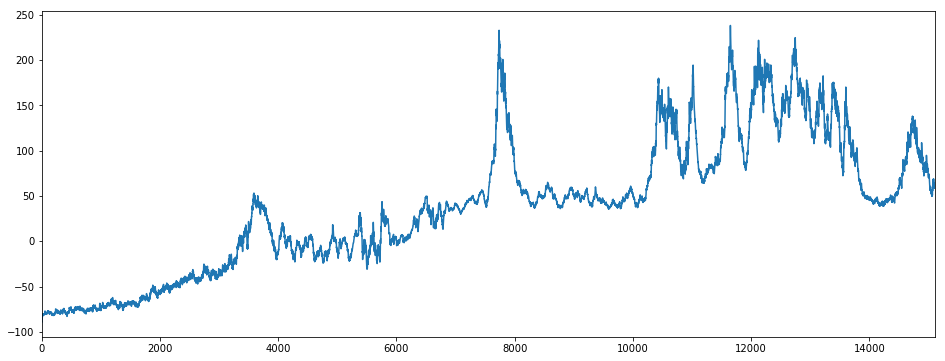

In [8]:
pd.Series(discount_reward_list).plot(figsize=(16,6))